In [ ]:
# %load hw2.py
import heapq
import os
import numpy as np
import cv2
from numpy.linalg import norm
from functools import reduce

x_slice = 5
y_slice = 5


# * [Grid Color Moments](http://homepages.inf.ed.ac.uk/rbf/CVonline/LOCAL_COPIES/AV0405/KEEN/av_as2_nkeen.pdf)

# In[96]:


def color_moments(img):
    if img is None:
        return
    # Convert BGR to HSV colorspace
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # Split the channels - h,s,v
    h, s, v = cv2.split(hsv)
    # Initialize the color feature
    color_feature = []
    # N = h.shape[0] * h.shape[1]
    # The first central moment - average
    h_mean = np.mean(h)  # np.sum(h)/float(N)
    s_mean = np.mean(s)  # np.sum(s)/float(N)
    v_mean = np.mean(v)  # np.sum(v)/float(N)
    color_feature.append([h_mean, s_mean, v_mean])
    # The second central moment - standard deviation
    h_std = np.std(h)  # np.sqrt(np.mean(abs(h - h.mean())**2))
    s_std = np.std(s)  # np.sqrt(np.mean(abs(s - s.mean())**2))
    v_std = np.std(v)  # np.sqrt(np.mean(abs(v - v.mean())**2))
    color_feature.append([h_std, s_std, v_std])
    # The third central moment - the third root of the skewness
    h_skewness = np.mean(abs(h - h.mean())**3)
    s_skewness = np.mean(abs(s - s.mean())**3)
    v_skewness = np.mean(abs(v - v.mean())**3)
    h_thirdMoment = h_skewness**(1./3)
    s_thirdMoment = s_skewness**(1./3)
    v_thirdMoment = v_skewness**(1./3)
    color_feature.append([h_thirdMoment, s_thirdMoment, v_thirdMoment])

    return np.array(color_feature)


# In[98]:


def prepare_reference(dataset, folder='Reference'):
    train_data_path = os.path.join(dataset, folder)
    images = sorted([item for item in os.listdir(
        train_data_path) if item != ".DS_Store"])
    total = len(images)

    print('-'*30)
    print('Preparing reference...')
    print('-'*30)

    image_moments = np.ndarray((total, x_slice, y_slice, 3, 3), np.float32)

    for idx, image_name in enumerate(images):
        img = cv2.imread(os.path.join(train_data_path, image_name))
        dx = img.shape[0] // x_slice
        dy = img.shape[1] // y_slice

        for i in range(x_slice):
            for j in range(y_slice):
                img_slice = img[i*dx:(i+1)*dx, j*dy:(j+1)*dy]
                slice_moment = color_moments(img_slice)
                image_moments[idx][i][j] = slice_moment

        if idx % 10 == 0:
            print(f'Done: {idx}/{total} images')

    print('Loading done.')

    np.save(f'{dataset}-{folder}.npy', image_moments)
    print(f'Saving to {dataset}-{folder}.npy files done.')


# In[99]:


def classify_data_with_reference(dataset, folder, reference):
    train_data_path = os.path.join(dataset, folder)
    images = sorted([item for item in os.listdir(
        train_data_path) if item != ".DS_Store"])

    total = len(images)

    print('-'*30)
    print(f'Classifying {folder}...')
    print('-'*30)

    top1_count = 0
    top5_count = 0

    weight = np.reshape(np.array(x_slice * y_slice * [
        [1, 0, 0],
        [0, 2, 0],
        [0, 0, 1]
    ]), (x_slice, y_slice, 3, 3))

    for idx, image_name in enumerate(images):
        img = cv2.imread(os.path.join(train_data_path, image_name))
        dx = img.shape[0] // x_slice
        dy = img.shape[1] // y_slice

        image_moment = np.ndarray((x_slice, y_slice, 3, 3), np.float32)

        for i in range(x_slice):
            for j in range(y_slice):
                img_slice = img[i*dx:(i+1)*dx, j*dy:(j+1)*dy]
                slice_moment = color_moments(img_slice)
                image_moment[i][j] = slice_moment

        possible_values = []
        for reference_index in range(reference.shape[0]):
            substracted_mat = np.subtract(
                reference[reference_index], image_moment)
            mat = np.matmul(substracted_mat, weight)
            distance = norm(mat)
            heapq.heappush(possible_values, (distance, reference_index))

        top5_values = []
        for i in range(5):
            top5_values.append(heapq.heappop(possible_values))
        top5 = [index for distance, index in top5_values]

        if idx in top5_values[0]:
            top1_count += 1
            print(f'hit: {image_name}! Distance:{top5_values[0][0]}')

        if idx in top5:
            top5_count += 1
            distance, index = [
                entry for entry in top5_values if entry[1] == idx][0]
            print(f'hit in top 5: {image_name}! Distance:{distance}')

        if idx % 10 == 0:
            print(f'Done: {idx}/{total} images')

    print('All done.')
    return top1_count, top5_count


# In[100]:

dataset_folder = 'dataset/museum_paintings'
dataset_list = [item for item in os.listdir(
    dataset_folder) if item not in [".DS_Store", "Reference"]]

if not os.path.isfile(f'{dataset_folder}-Reference.npy'):
    prepare_reference(dataset_folder)
reference = np.load(f'{dataset_folder}-Reference.npy')

result = {}
top1result = 0
top5result = 0
total_count = 0
for entry in dataset_list:
    result[entry] = classify_data_with_reference(
        dataset_folder, entry, reference)
    top1result += result[entry][0]
    top5result += result[entry][1]
    total_count += len(reference)

print(f"top1:{top1result/total_count}")
print(f"top5:{top5result/total_count}")


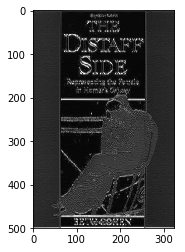

In [8]:
# %load test.py
import cv2
import numpy as np
import matplotlib.pyplot as plt
# define gabor filter bank with different orientations and at different scales


def build_filters():
    filters = []
    ksize = 9
    # define the range for theta and nu
    for theta in np.arange(0, np.pi, np.pi / 8):
        for nu in np.arange(0, 6*np.pi/4, np.pi / 4):
            kern = cv2.getGaborKernel(
                (ksize, ksize), 1.0, theta, nu, 0.5, 0, ktype=cv2.CV_32F)
            kern /= 1.5*kern.sum()
            filters.append(kern)
    return filters

# function to convolve the image with the filters


def process(img, filters):
    accum = np.zeros_like(img)
    for kern in filters:
        fimg = cv2.filter2D(img, cv2.CV_8UC3, kern)
        np.maximum(accum, fimg, accum)
    return accum


if __name__ == '__main__':

    # instantiating the filters
    filters = build_filters()

    f = np.asarray(filters)

    # reading the input image
    image = cv2.imread('dataset/book_covers/Reference/001.jpg', 0)

    # initializing the feature vector
    feat = []
    feat2 = []
    # calculating the local energy for each convolved image
    for j in range(40):
        res = process(image, f[j])
        temp = 0
        temp2 = 0
        for p in range(128):
            for q in range(128):
                # calculating the mean amplitude for each convolved image
                temp = temp + res[p][q]**2
                # feat matrix is the feature vector for the image
                temp2 = temp2 + abs(res[p][q])
        feat.append(temp)
        feat2.append(temp2)
    
    plt.imshow(res, cmap='gray')
    plt.show()


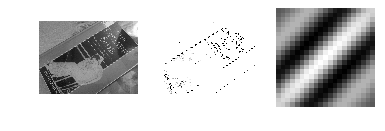

In [14]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


g_kernel = cv2.getGaborKernel((21, 21), 8.0, np.pi/4, 10.0, 0.5, 0, ktype=cv2.CV_32F)

img = cv2.imread('dataset/book_covers/Droid/001.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
filtered_img = cv2.filter2D(img, cv2.CV_8UC3, g_kernel)

plt.subplot(131).imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(132).imshow(filtered_img, cmap='gray')
plt.axis('off')

h, w = g_kernel.shape[:2]
# g_kernel = cv2.resize(g_kernel, (3*w, 3*h), interpolation=cv2.INTER_CUBIC)
plt.subplot(133).imshow(g_kernel, cmap='gray')
plt.axis('off')

plt.show()